In [21]:
import deap
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import keras_tuner as kt
from deap import base, creator, tools, algorithms
import random
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd


# Parametros del problema

In [22]:
L = 1
g = 9.81
m = 0.25


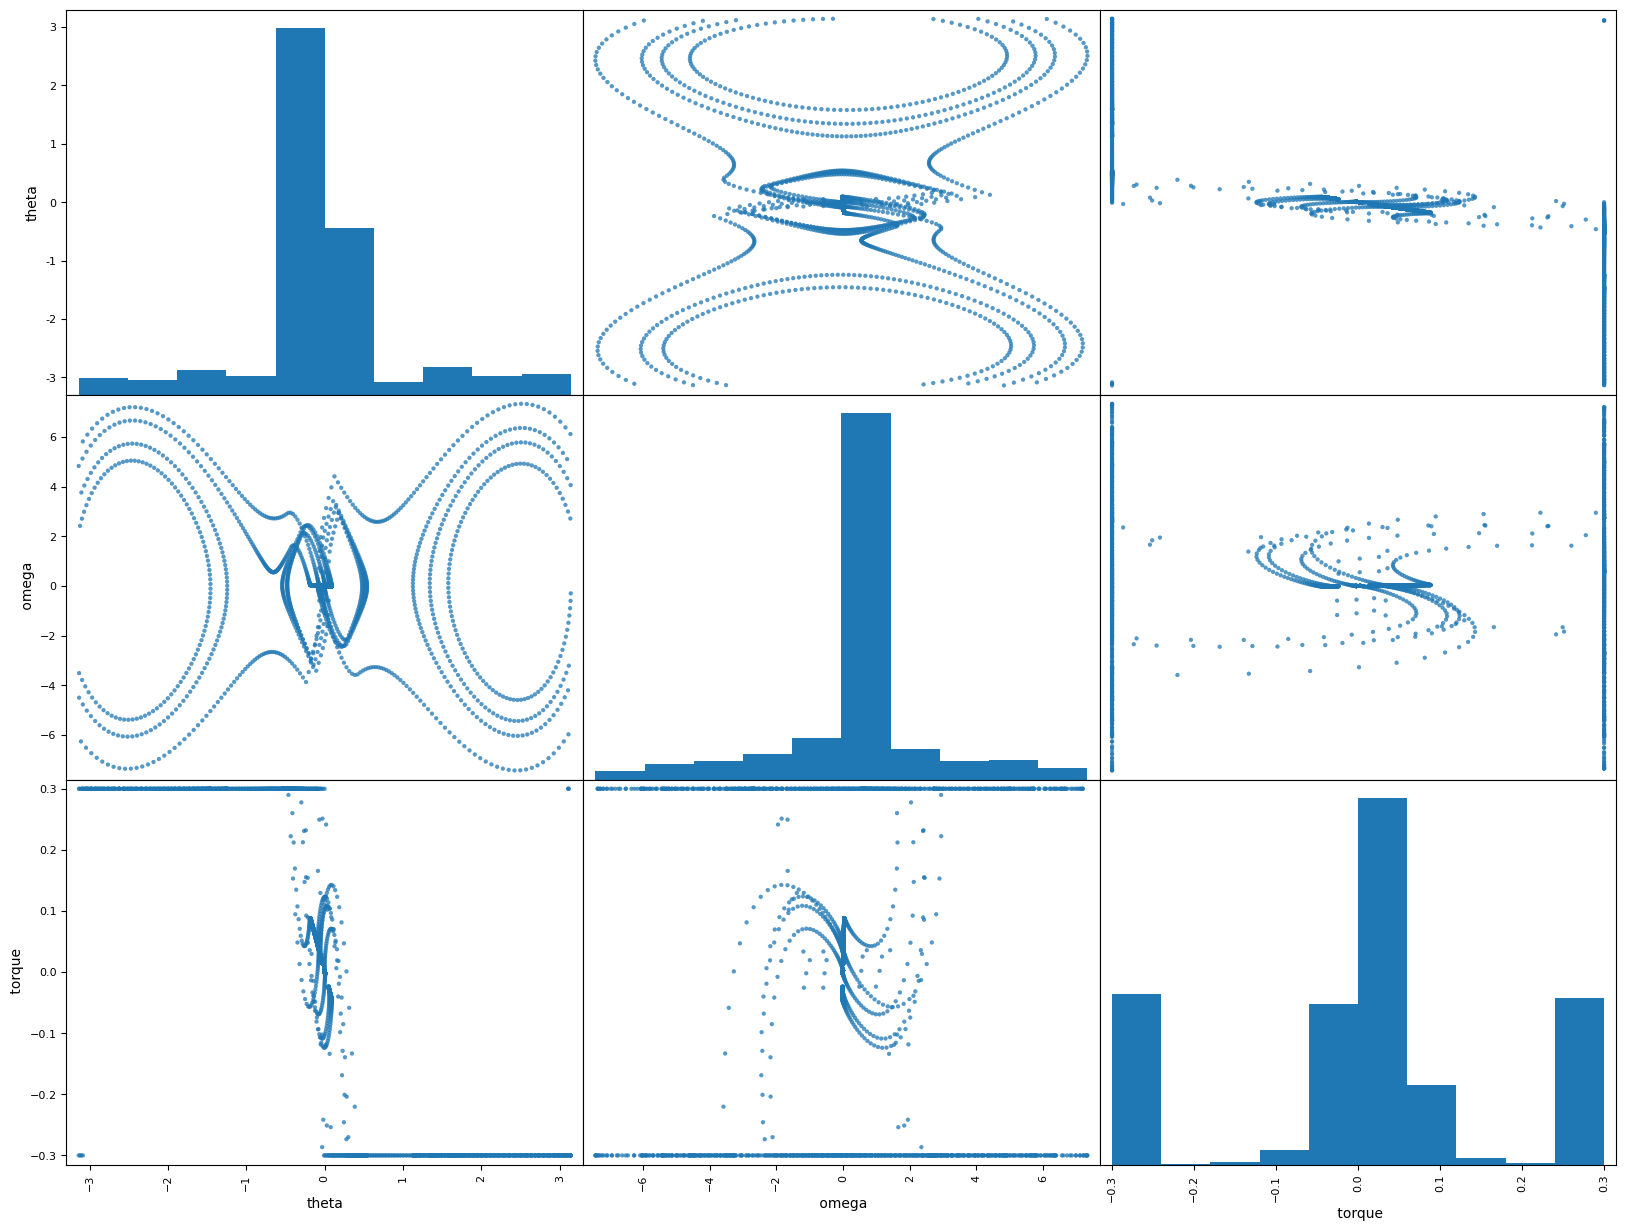

In [15]:
dataset = pd.read_csv('dataset.csv')

pd.plotting.scatter_matrix(dataset, figsize=(20, 15))
plt.show()

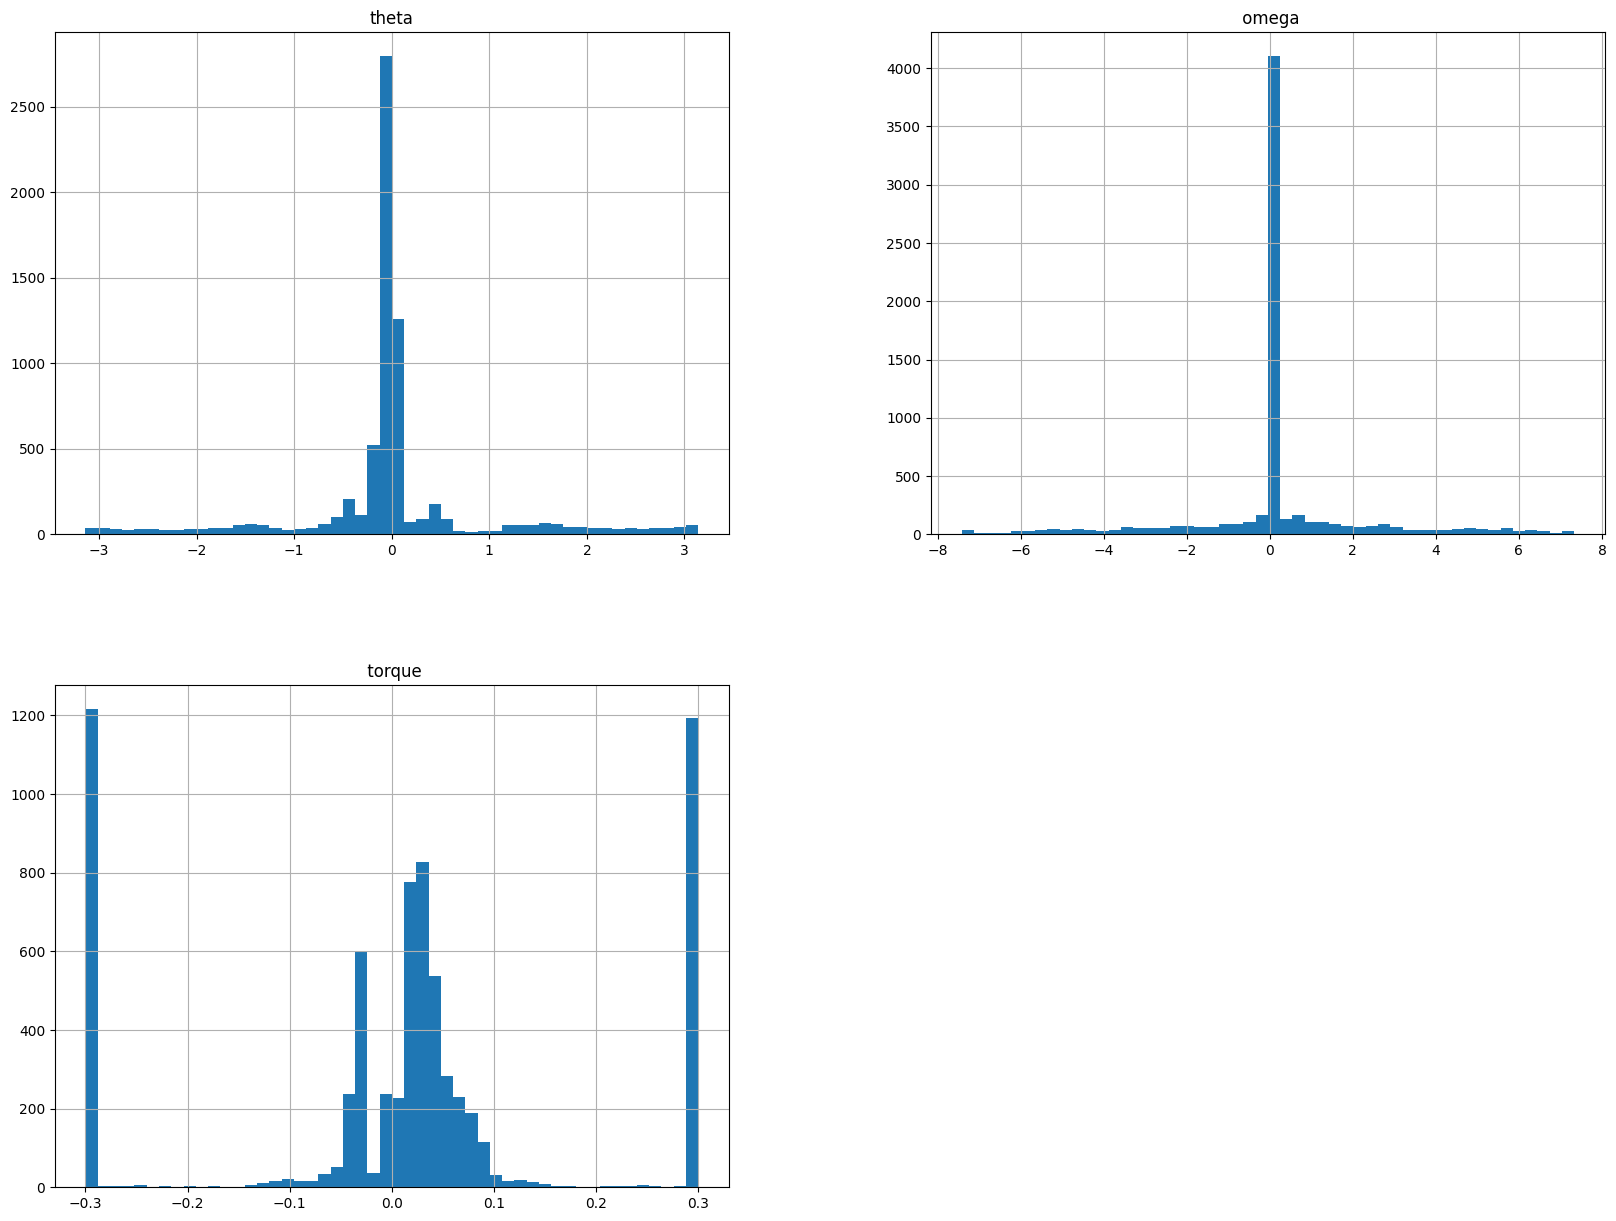

In [16]:
dataset.hist(figsize=(20, 15), bins=50) #Se observa la frecuencia de cada uno de los valores de las variables
plt.show()

In [27]:
# col_min = dataset.min(axis=0)
# col_max = dataset.max(axis=0)

# # 2) normalize: for each column, subtract its min and divide by its range
# dataset = (dataset - col_min) / (col_max - col_min)

# print("Column minima:\n", col_min)
# print("Column maxima:\n", col_max)
# print("Normalized DataFrame:\n", dataset)

train_set = dataset.sample(frac=0.8, random_state=0)
test_set = dataset.drop(train_set.index)


print(train_set.shape)
# BURN, ESTOS SE USAN PARA ENTRENAR LA RED CON DESCENSO DE GRADIENTE, Y
# EN LA PRUEBA DE HIPER PARAMETROS. NO SE USAN PARA EL ALGORITMO EVOLUTIVO
X_train = train_set.iloc[:, :2].values
Y_train = train_set.iloc[:, 2:].values

X_test = test_set.iloc[:, :2].values
Y_test = test_set.iloc[:, 2:].values

# Parameters
batch_size = 20

# ESTOS SE USAN PARA EL ALGORITMO EVOLUTIVO
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)) \
    .shuffle(buffer_size=len(X_train)) \
    .batch(batch_size) \
    .prefetch(tf.data.AUTOTUNE)
    #.repeat()

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)) \
    .batch(batch_size) \
    .prefetch(tf.data.AUTOTUNE)


#list(train_dataset)[2][0]

(5602, 3)


In [24]:
class HyperParamTuner(kt.HyperModel):

    def build(self, hp):
        '''
        Construye el modelo de la red. hp es un parametro que permite que
        la clase de keras tuner pueda modificar los parametros del modelo
        automáticamente.
        '''
        # Se genera una capa de normalización, la cual
        # normaliza las entradas de la red
        norm_layer = tf.keras.layers.Normalization(axis=-1)
        # Se entrena con los datos de entrenamiento
        norm_layer.adapt(np.array(X_train))

        # se inicializa un modelo secuencial, y se le adiciona la capa
        # de normalización como la primera capa de la red
        model = keras.Sequential()
        model.add(norm_layer)
        # Se definen los hiperparametros, así como
        # los valores que pueden tomar
        num_layers = 1 #hp.Int('num_layers', min_value=1, max_value=1, step=1)
        activation_function = hp.Choice(
            'activation_function', values=['tanh', 'sigmoid'])

        num_units = hp.Int('num_neurons',
                           min_value=3,
                           max_value=10,
                           step=1)
        for i in range(num_layers):
            model.add(layers.Dense(num_units,
                                   activation=activation_function))

        # Se adiciona la capa de salida
        model.add(layers.Dense(1, activation='linear'))
        # Se establece como hiperparametro la función de pérdida
        loss_func = hp.Choice('loss_function', values=['mse', 'mae'])

        model.compile(
            optimizer=keras.optimizers.Adam(
                # permite poner la taza de aprendizaje como hiperparametro
                hp.Choice('learning_rate', [1e-2, 1.5e-2, 1e-3, 1.5e-3, 1e-4])),
            loss=loss_func,
            metrics=['mae'])
        return model

    def fit(self, hp, model, X_train,
            Y_train,
            epochs=200,
            # validation_split=test_percentage,
            validation_data=(X_test, Y_test),
            # termina el entrenamiento si no hay mejora en la función de pérdida
            callbacks=[tf.keras.callbacks.EarlyStopping(
                monitor='val_mae', patience=5)],
            verbose=False):

        # Se coloca el batchsize como hiperparametro
        batch = hp.Int('batch_size', min_value=5, max_value=150, step=15)
        return model.fit(
            X_train,
            Y_train,
            epochs=1000,
            batch_size=batch,
            # validation_split=test_percentage,
            validation_data=(X_test, Y_test),
            callbacks=[tf.keras.callbacks.EarlyStopping(
                monitor='val_mae', patience=5)],
            verbose=False)

In [25]:
tuner = kt.RandomSearch(
    HyperParamTuner(),
    objective='val_mae',  # Se busca minimizar el error absoluto medio
    max_trials=15,  # Número de combinaciones de hiperparámetros a probar
    # Número de veces que se entrena cada combinación de hiperparámetros. De esta forma se
    executions_per_trial=2,
    # evita que si en un entrenamiento se obtiene un resultado muy bueno o muy malo, se actúe
    # inmediatamente sobre esa información, ya que ese resultado pudo haber ocurrido por suerte.
    directory='tests',
    project_name='Field Current',
    overwrite=False)


tuner.search_space_summary()

Search space summary
Default search space size: 4
activation_function (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh', 'sigmoid'], 'ordered': False}
num_neurons (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 10, 'step': 1, 'sampling': 'linear'}
loss_function (Choice)
{'default': 'mse', 'conditions': [], 'values': ['mse', 'mae'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.015, 0.001, 0.0015, 0.0001], 'ordered': True}


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae',
    mode='min',
    patience=5
)
# Se inicia la búsqueda de hiperparámetros
tuner.search(X_train,
             Y_train,
             epochs=1000,
             #validation_split=0.2,
             validation_data=(X_test, Y_test),
             callbacks=[stop_early],

             verbose=False)l

In [31]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0] # Se obtienen los mejores hiperparámetros
print("Best hyperparameters:", best_hps.values)

Best hyperparameters: {'activation_function': 'sigmoid', 'num_neurons': 8, 'loss_function': 'mae', 'learning_rate': 0.0015, 'batch_size': 35}


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_2 (Normalization) │ (None, 2)              │             5 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 106 (432.00 B)

 Trainable params: 33 (132.00 B)

 Non-trainable params: 5 (24.00 B)

 Optimizer params: 68 (276.00 B)

Layer `normalization_2` (Normalization):
  ▶ Array #0: shape = (2,)
[-0.00488371  0.0949228 ]
  ▶ Array #1: shape = (2,)
[0.94199693 4.897283  ]
  ▶ Array #2: shape = ()
0
------------------------------------------------------------
Layer `dense_4` (Dense):
  ▶ Array #0: shape = (2, 8)
[[-3.5028038   0.6981555   0.27811775  0.4675547   0.29573447 -0.30830947
  -0.27737063 -0.41643232]
 [-0.8316319   0.13060294 -0.9297989   0.00486238 -0.55750626  0.77819854
   2.191805    0.46321887]]
  ▶ Array #1: shape = (8,)
[-0.06229617 -0.00874073 -0.02056126  0.0106181  -0.02685367 -0.03527381
 -0.07647112 -0.0557423 ]
------------------------------------------------------------
Layer `dense_5` (Dense):
  ▶ Array #0: shape = (8, 1)
[[ 0.7161706 ]
 [ 0.65383375]
 [-0.64282495]
 [-0.7791581 ]
 [ 0.51227385]
 [-0.24226286]
 [-0.11410852]
 [ 0.02946497]]
  ▶ Array #1: shape = (1,)
[-0.06697445]
------------------------------------------------------------
Test Loss: 0.020759372040629387, Test Mean Abs

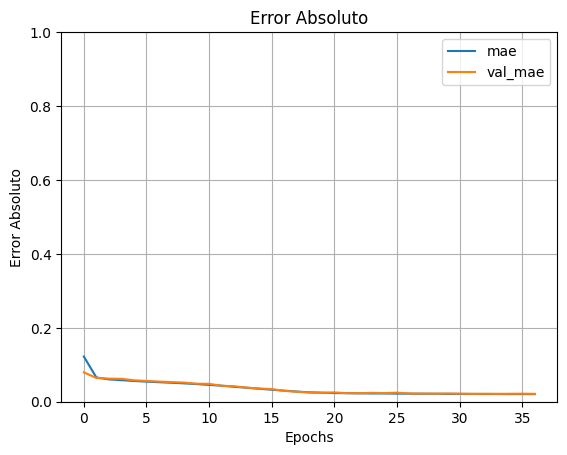

In [34]:
model = tuner.hypermodel.build(best_hps) #Se compila el mejor modelo


history = model.fit(X_train,
                    Y_train,
                    epochs=1000,
                    batch_size=best_hps.get('batch_size'),
                    validation_split=0.2,  # Use validation data
                    callbacks=[stop_early],
                    verbose=False)

def print_model_weights(model):
    """
    Prints the weight arrays of each layer in `model` in an orderly fashion.
    """
    for layer in model.layers:
        weights = layer.get_weights()
        if not weights:
            continue
        print(f"Layer `{layer.name}` ({layer.__class__.__name__}):")
        for idx, w in enumerate(weights):
            print(f"  ▶ Array #{idx}: shape = {w.shape}")
            # Optionally, for very large arrays you can limit the printout:
            # print(np.array2string(w, max_line_width=100, precision=4, threshold=10))
            print(w)
        print("-" * 60)
model.summary()

print_model_weights(model)
test_loss, test_mae = model.evaluate(X_train, Y_train, verbose=0)
print(f'Test Loss: {test_loss}, Test Mean Absolute Error: {test_mae}')
loss_df = pd.DataFrame(history.history)
print(loss_df.head())
# Plot the loss and validation loss
loss_df.loc[:, ['mae', 'val_mae']].plot()
plt.ylim(0, 1)
plt.title('Error Absoluto')
plt.xlabel('Epochs')
plt.ylabel('Error Absoluto')
plt.grid()

# $Individuo = [W_1, B_1, W_2, B_2, ..., W_n, B_n]$

In [55]:
def WeightsPlacer(individual, tuner):
    '''
    Toma los pesos, que se encuentran en el individuo
    y los convierte en forma tensorial para poder
    ser colocados en el modelo
    '''
    best_config = tuner.get_best_hyperparameters(num_trials=1)[0]
    model = tuner.hypermodel.build(best_config) 

    idx = 0
    tensors=[]
    offset = 0
    # 2) Iterate only Dense layers
    for layer in model.layers:
        if not isinstance(layer, tf.keras.layers.Dense):
            continue

        # 3) Grab existing arrays [kernel, bias]
        orig_weights = layer.get_weights()
        new_weights = []

        for w in orig_weights:
            # How many genes this array needs:
            n_params = w.size

            # Slice exactly that many (and advance our counter!)
            chunk = individual[offset : offset + n_params]
            offset += n_params

            # Reshape back to the original shape
            new_weights.append(np.array(chunk).reshape(w.shape))

        # 4) Overwrite this layer’s weights in one go
        layer.set_weights(new_weights)

    # # Sanity check
    # assert offset == len(individual), (
    #     f"Used {offset} genes but individual has {len(individual)}."
    # )

    return model

errors = []
def Fitness_Function(individual, train_dataset, batch_size, step, tuner):
    global errors
    #Create the model
     #CHANGE THIS BUILD USING HYPERPARMS
    #Set the weights

    model = WeightsPlacer(individual=individual, tuner=tuner)
    
    N = len(train_dataset)
    if step > N-1:
        skip_step = step % N
    else:
        skip_step = step
    
    
    ds_batch = train_dataset.skip(skip_step).take(1)
    x_batch, y_batch = next(iter(ds_batch))
  

    mae_per_batch = np.abs(model.predict(tf.squeeze(x_batch)) - y_batch)

    Average_training_torque = int(np.mean(mae_per_batch))
    errors.append(Average_training_torque)
    return (Average_training_torque,)
             

In [37]:
def Training_Loop(population, toolbox, mu, lambda_, cxpb, mutpb, ngen,train_dataset, batch_size,tuner,
                   stats=None, halloffame=None, verbose=__debug__ ):
    r"""This is the :math:`(\mu + \lambda)` evolutionary algorithm.
    """
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = []
    curr_step = 0
    for ind in invalid_ind:
        fitnesses.append(Fitness_Function(ind, train_dataset, batch_size, curr_step, tuner))

    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats is not None else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):
        print("Generation: ", gen)
        # Vary the population
        offspring = deap.algorithms.varOr(population, toolbox, lambda_, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        #fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        fitnesses = []
        for ind in invalid_ind:
            fitnesses.append(Fitness_Function(ind, train_dataset, batch_size, gen, tuner))
            
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Select the next generation population
        population[:] = toolbox.select(population + offspring, mu)

        # Update the statistics with the new population
        record = stats.compile(population) if stats is not None else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

In [56]:
lower = -0.1 #
upper = 0.1
tournament_size = 3
population_size = 100
parent_popu_size = population_size//2
mate_probability = 0.5
parent_popu_size = 50
child_popu_size = 50
mutate_probability = 0.1
generations = 50
alpha           = 0.5    # blend factor for crossover (cxBlend)
mu              = 0.0    # mean for Gaussian mutation
sigma           = 0.015    # standard deviation for Gaussian mutation
indpb           = 0.2    # per‐gene mutation probability
tournament_size = 3

In [45]:
toolbox = base.Toolbox()
creator.create("Fitness_Mono", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.Fitness_Mono)
# Se añaden las operaciones necesarias para la creacion de individuos y poblacion,
# asi como la funcion de evaluacion.

toolbox.register("P", random.uniform, lower, upper) #Esto genera las entradas del individuo. P de parameter
toolbox.register("individual", tools.initRepeat,
                 creator.Individual, toolbox.P, n=33) #ESTO SE VE CON LOS HIPERPARAMETROS!!!!!!
toolbox.register("population", tools.initRepeat, list,
                 toolbox.individual, n=population_size)

def checkBounds(min1, max1):
    def decorator(func):
        def wrapper(*args, **kwargs):
            offspring = func(*args, **kwargs)
            for child in offspring:
                # Check the first gene (index 0)
                if child[0] > max1:
                    child[0] = max1
                elif child[0] < min1:
                    child[0] = min1
            return offspring
        return wrapper
    return decorator
toolbox.register("mate", tools.cxBlend, alpha=alpha)
toolbox.register("mutate", tools.mutGaussian, mu=mu, sigma=sigma, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=tournament_size)
toolbox.decorate("mate", checkBounds(lower, upper))
toolbox.decorate("mutate", checkBounds(lower, upper))

/home/carnifex/miniconda3/envs/ML_Sci_computing/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Fitness_Mono' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/carnifex/miniconda3/envs/ML_Sci_computing/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [46]:
# Estadísticas del fitness general de la población
# Codigo proporcionado en las guias del curso
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)  # Promedio de la gen
stats.register("std", np.std)  # Desviación estándar de los individuos
stats.register("min", np.min)  # Fitness mínimo de la gen
stats.register("max", np.max)  # Fitness máximo de la gen

In [57]:
hof = tools.HallOfFame(1)
population = toolbox.population()
evolved_population, logbook = Training_Loop(
    population=population,
    toolbox=toolbox,
    mu=parent_popu_size,
    lambda_=child_popu_size,
    cxpb=mate_probability,
    mutpb=mutate_probability,
    ngen=generations,
    train_dataset= train_dataset,
    batch_size = batch_size,
    tuner = tuner,
    stats=stats,
    halloffame=hof
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

[-0.02977050539100832, 0.0677687525331223, -0.11049688420679735, -0.011129510887514786, 0.11137126880774048, 0.058354868923435076, 0.09350695475571703, -0.02890130273065771, 0.047998887196571485, -0.03611137656164578, -0.05918829174351067, 0.039169723413639834, 0.016196360446276793, -0.058641258654538404, 0.011365040997699671, 0.014073784679548874, 0.14555404604158848, -0.04724856471588188, 0.1721185503003729, 0.10014958799567521, 0.04150944999585516, -0.018139425373055004, -0.010515280220794279, 0.0607871482015237, 0.05300140966772522, 0.24524512001760224, -0.060204700473764555, -0.07661962652906637, -0.1453932731619092, 0.08333391895497576, 0.016138319871832604, 0.0866939429733086, -0.08116141990147586]
Layer `normalization_10082` (Normalization):
  ▶ Array #0: shape = (2,)
[-0.00488371  0.0949228 ]
  ▶ Array #1: shape = (2,)
[0.94199693 4.897283  ]
  ▶ Array #2: shape = ()
0
------------------------------------------------------------


Model: "sequential_10082"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_10082             │ (None, 2)              │             5 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20164 (Dense)             │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20165 (Dense)             │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38 (156.00 B)

 Trainable params: 33 (132.00 B)

 Non-trainable params: 5 (24.00 B)

Test Loss: 0.3467957675457001, Test Mean Absolute Error: 0.3467957675457001


/tmp/ipykernel_2159372/1007857983.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


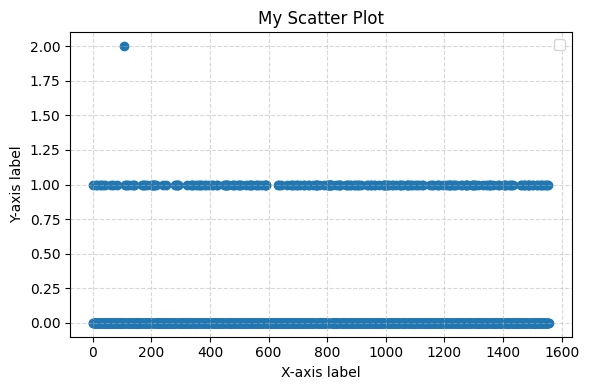

In [59]:
best_individual = tools.selBest(evolved_population, k=1)[0]
print(best_individual)
modelo_a_utilizar = WeightsPlacer(best_individual, tuner)
print_model_weights(modelo_a_utilizar)

test_loss, test_mae = modelo_a_utilizar.evaluate(X_test, Y_test, verbose=0)
modelo_a_utilizar.summary()
print(f'Test Loss: {test_loss}, Test Mean Absolute Error: {test_mae}')
plt.figure(figsize=(6,4))
plt.scatter(
   range(len(errors)) ,errors
)
plt.title("My Scatter Plot")
plt.xlabel("X-axis label")
plt.ylabel("Y-axis label")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [ ]:
modelo_a_utilizar.predict((X_test))

TypeError: 'iterator' object is not subscriptable

In [ ]:
modelo_a_utilizar.save("TrainedModel.keras", overwrite=True) # Se guarda el modelo de rendimiento satisfactorio.

In [ ]:

def step_point_mass_pendulum(theta, omega, tau, dt, m=1.0, l=1.0, g=9.81):
    """
    Compute next theta, omega, alpha for an inverted pendulum with a point mass.

    Parameters:
        theta (float): Angle (rad)
        omega (float): Angular velocity (rad/s)
        tau (float): Applied torque (N·m)
        dt (float): Time step (s)
        m (float): Mass (kg)
        l (float): Length (m)
        g (float): Gravity (m/s²)

    Returns:
        theta_next (float)
        omega_next (float)
        alpha_next (float)
    """
    def dynamics(t, y):
        posicion_angular, velocidad_angular = y
        aceleracion_angular = (tau / (m * l**2)) - (g / l) * np.sin(θ)
        return [velocidad_angular, aceleracion_angular]

    sol = solve_ivp(
        dynamics,
        t_span=(0, dt),
        y0=[theta, omega],
        method='RK45',
        t_eval=[dt]
    )

    theta_next, omega_next = sol.y[:, -1]
    alpha_next = (tau / (m * l**2)) - (g / l) * np.sin(theta_next)

    return theta_next, omega_next, alpha_next
